In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
from utils.session_data import SessionData
import utils.io_utils as io_utils

import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from dPCA.dPCA import dPCA

In [3]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [4]:
sessions = pd.read_pickle(SESSIONS_PATH)

In [46]:
modes = ["FiringRate", "SpikeCounts"]
zmodes = ["ZFiringRate", "ZSpikeCounts"]
def calc_psth_per_session(row, conditions):
    sess_name = row.session_name
    beh, frs = io_utils.load_rpe_sess_beh_and_frs(sess_name)
    if frs.SpikeCounts.isnull().values.any():
        print("null valuessssss")

    def zscore_unit(group):
        for mode in modes: 
            mean = group[mode].mean()
            std = group[mode].std()
            group[f"Z{mode}"] = 0 if std == 0 else (group[mode] - mean) / std
        return group
    frs = frs.groupby(["UnitID"]).apply(zscore_unit)
    if frs.ZFiringRate.isnull().values.any():
        raise ValueError("Why are there null values after zscoring")
    merged = pd.merge(beh[conditions], frs, on="TrialNumber")
    group_conds = conditions + ["UnitID", "TimeBins"]
    psth = merged.groupby(group_conds).mean()[modes + zmodes].reset_index()
    psth["PseudoUnitID"] = int(sess_name) * 100 + psth["UnitID"]
    return psth

In [ ]:
dim_psths = []
for feature_dim in FEATURE_DIMS:
    conditions = ["RPEGroup", feature_dim]
    dim_psth = pd.concat(sessions.apply(lambda x: calc_psth_per_session(x, conditions), axis=1).values)
    dim_psth = dim_psth.rename(columns={feature_dim: "Feature"})
    dim_psths.append(dim_psth)
full_psth = pd.concat(dim_psths)

In [49]:
full_psth.to_pickle("/data/patrick_res/rpe_features_psth.pickle")

In [50]:
full_psth = pd.read_pickle("/data/patrick_res/rpe_features_psth.pickle")

In [51]:
# SHAPES = ["CIRCLE", "SQUARE", "STAR", "TRIANGLE"]
# RPE_GROUPS = ["less neg", "less pos", "more neg", "more pos"]
SHAPES = ["CIRCLE", "TRIANGLE"]
RPE_GROUPS = ["more neg", "more pos"]

In [52]:
psth_shapes = full_psth[full_psth.Feature.isin(SHAPES) & full_psth.RPEGroup.isin(RPE_GROUPS)]

In [63]:
psth_shapes.sort_values(by=["PseudoUnitID", "TimeBins", "Feature", "RPEGroup"])
np_arr = psth_shapes["SpikeCounts"].to_numpy()

In [64]:
num_units = len(psth_shapes.PseudoUnitID.unique())
num_timebins = len(psth_shapes.TimeBins.unique())
num_shapes = len(SHAPES)
num_rpe_groups = len(RPE_GROUPS)
data = np_arr.reshape((num_units, num_timebins, num_shapes, num_rpe_groups))

In [68]:
dpca = dPCA(
    labels='tfr', 
    join={'tf' : ['f','tf'], 'tr': ['r', 'tr'], 'tfr': ['fr', 'tfr']},
    regularizer='auto'
)
dpca.protect = ['t']
res = dpca.fit_transform(data)

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.


ValueError: To optimize the regularization parameter, the trial-by-trial data trialX needs to be provided.

In [66]:
res.keys()

dict_keys(['t', 'tf', 'tr', 'tfr'])

(10, 28, 2, 2)
(10, 28, 2, 2)
(10, 28, 2, 2)
(10, 28, 2, 2)


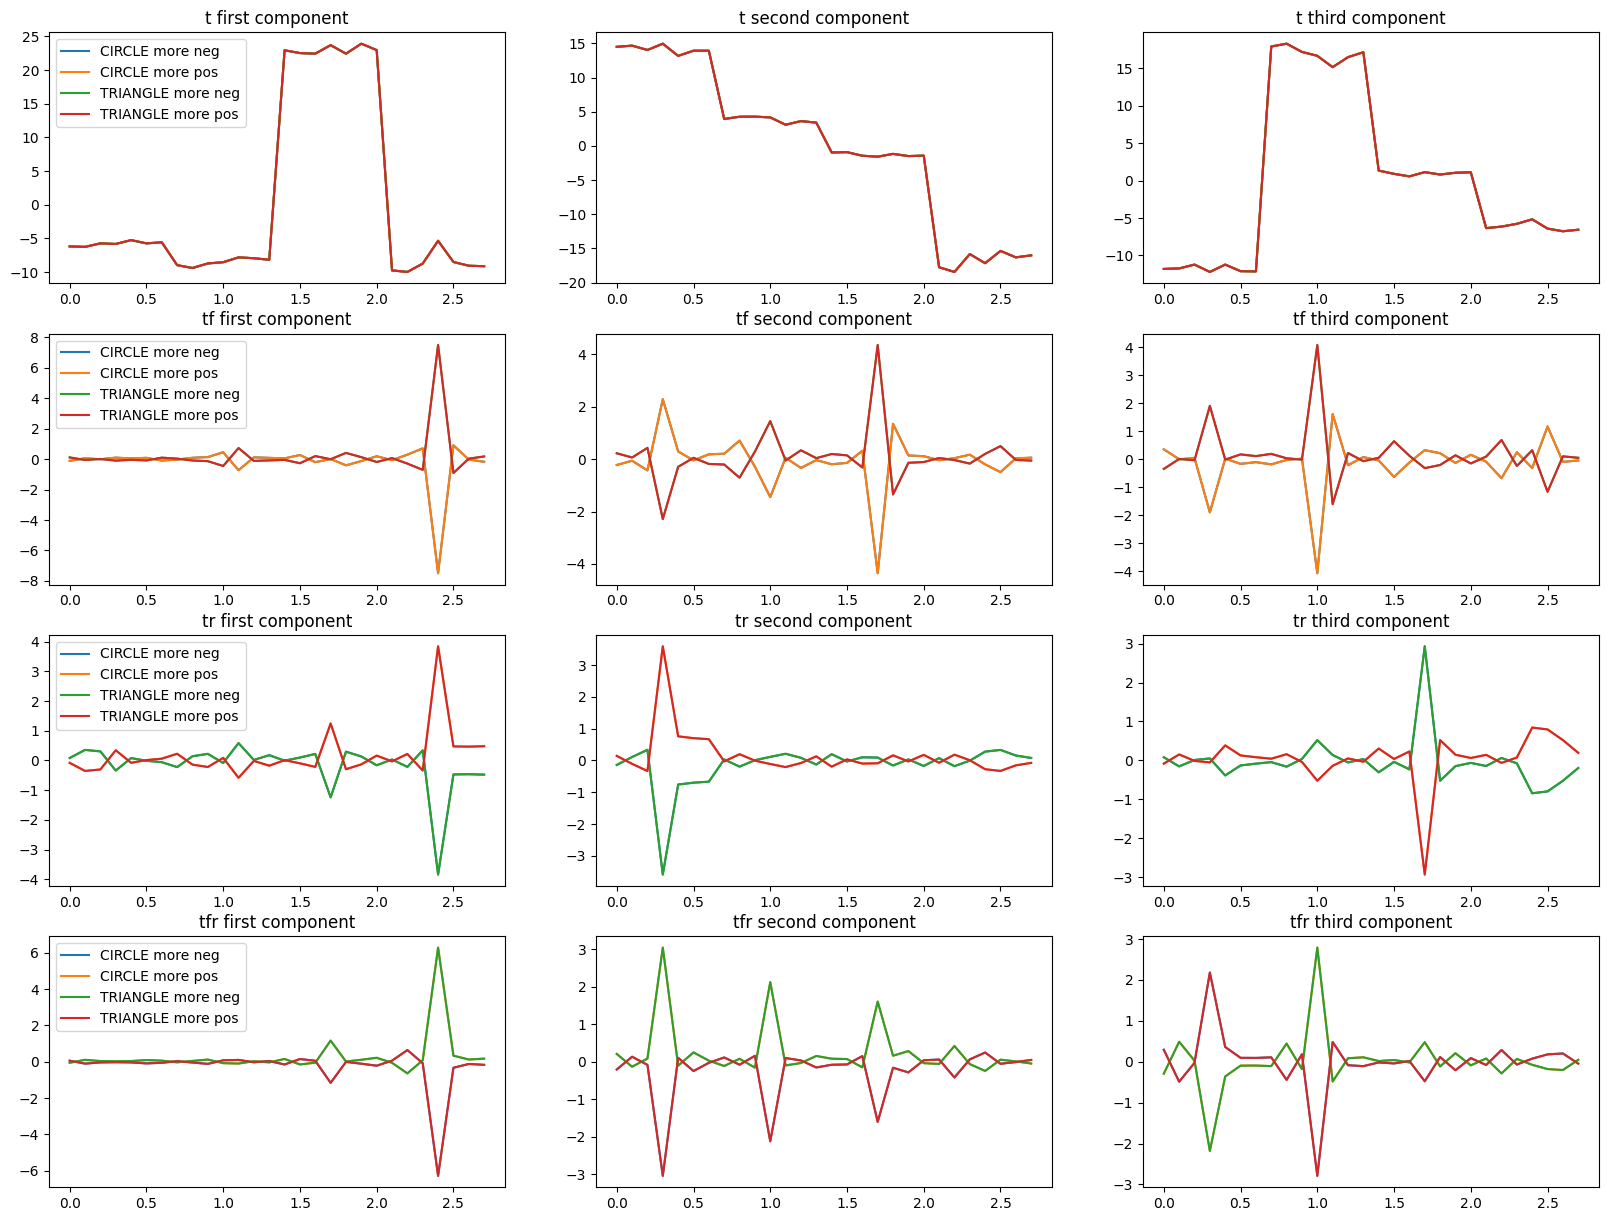

In [67]:
fig, axs = plt.subplots(4, 3, figsize=(20, 15))
x = np.arange(0, 2.8, 0.1)
for comp_idx, comp in enumerate(res):
    mat = res[comp]
    print(mat.shape)
    for f_idx, f in enumerate(SHAPES):
        for r_idx, r in enumerate(RPE_GROUPS):
            axs[comp_idx, 0].plot(x, mat[0, :, f_idx, r_idx], label=f"{f} {r}")
            axs[comp_idx, 1].plot(x, mat[1, :, f_idx, r_idx], label=f"{f} {r}")
            axs[comp_idx, 2].plot(x, mat[2, :, f_idx, r_idx], label=f"{f} {r}")

            axs[comp_idx, 0].legend()
            axs[comp_idx, 0].set_title(f"{comp} first component")
            axs[comp_idx, 1].set_title(f"{comp} second component")
            axs[comp_idx, 2].set_title(f"{comp} third component")